In [675]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import Image
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score

In [676]:
df = pd.read_csv('supermarket_sales.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [677]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


# EDA

In [678]:
#EDA

#removendo valores duplicados
df.drop_duplicates(inplace=True)

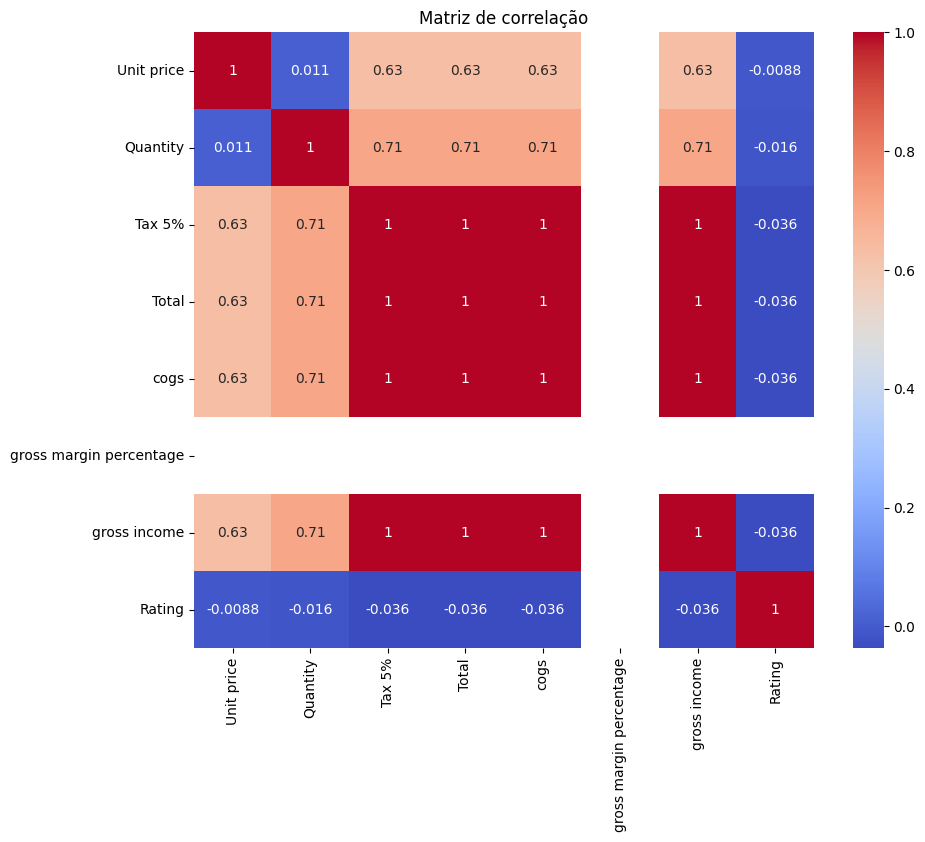

In [679]:
#Matriz

dfNum = df.select_dtypes(include=np.number)
correlation = dfNum.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Matriz de correlação')
plt.show()

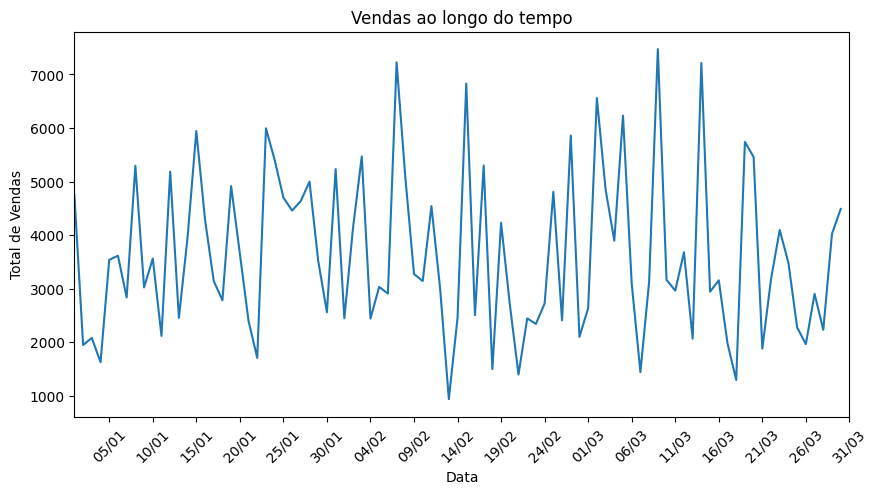

In [680]:
#Distribuição das Vendas

#Vendas ao longo do tempo

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Hour'] = df['Time'].str.split(':').str[0].astype(int)
df['Minute'] = df['Time'].str.split(':').str[1].astype(int)

plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
plt.plot(df.groupby('Date')['Total'].sum())
plt.title('Vendas ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-03-31'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.show()

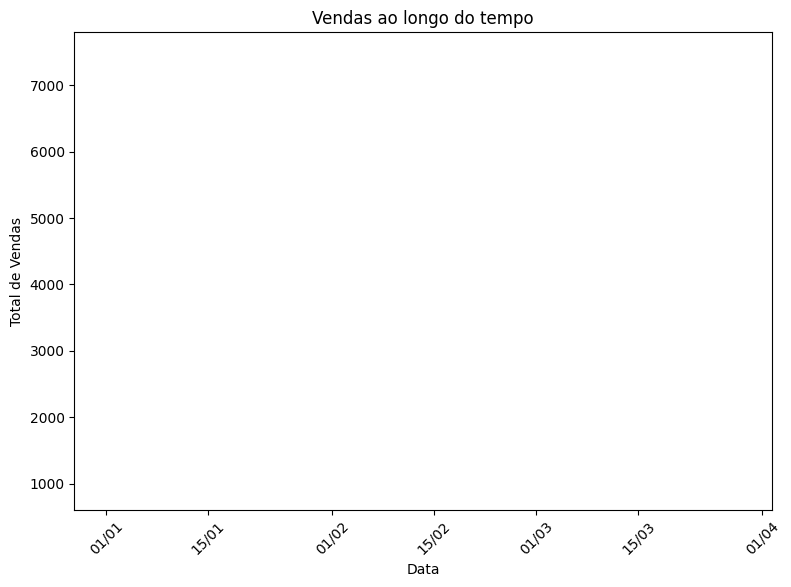

In [681]:
#Gráfico animado das vendas ao longo do tempo com a linha andando ao longo do tempo

date_for = mdates.DateFormatter('%d/%m')

fig, ax = plt.subplots(figsize=(9,6.2))
def anim(i):
    data = df.groupby('Date')['Total'].sum().head(i)
    ax.clear()
    ax.plot(data)
    ax.xaxis.set_major_formatter(date_for)
    plt.xticks(rotation=45)
    plt.title('Vendas ao longo do tempo')
    plt.xlabel('Data')
    plt.ylabel('Total de Vendas')

ani = animation.FuncAnimation(fig, anim, frames=len(df['Date'].unique()), repeat=True)

#salvando em mp4
ani.save('vendas.gif', writer='pillow', fps=9)

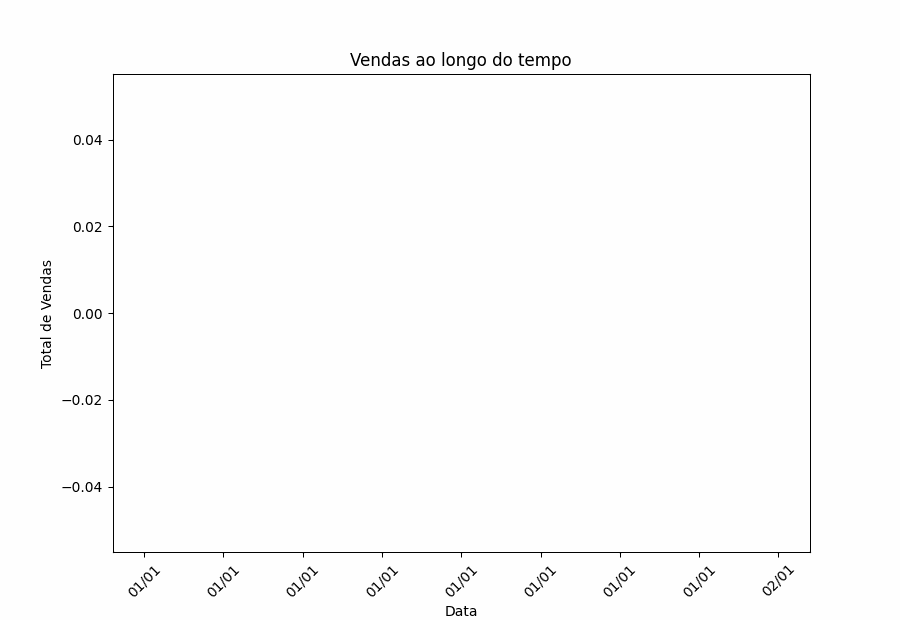

In [682]:
#Carregar o gif
Image('vendas.gif')

In [683]:
dfDiaSemana = df.copy()
dfDiaSemana['Weekday'] = df['Weekday'].replace({0: 'Dom', 1: 'Seg', 2: 'Ter', 3: 'Qua', 4: 'Qui', 5: 'Sex', 6: 'Sáb'})

dfDiaSemana['Weekday'] = dfDiaSemana['Weekday'].astype('category')
dfDiaSemana['Weekday'] = dfDiaSemana['Weekday'].cat.reorder_categories(['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb'], ordered=True)

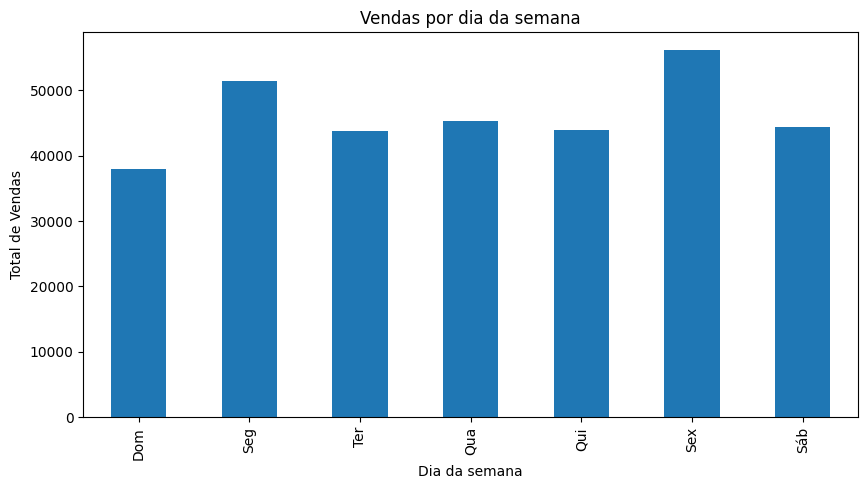

In [684]:
#Analisando as vendas por semana

plt.figure(figsize=(10,5))
dfDiaSemana.groupby('Weekday', observed=True)['Total'].sum().plot(kind='bar')
plt.title('Vendas por dia da semana')
plt.xlabel('Dia da semana')
plt.ylabel('Total de Vendas')
plt.show()

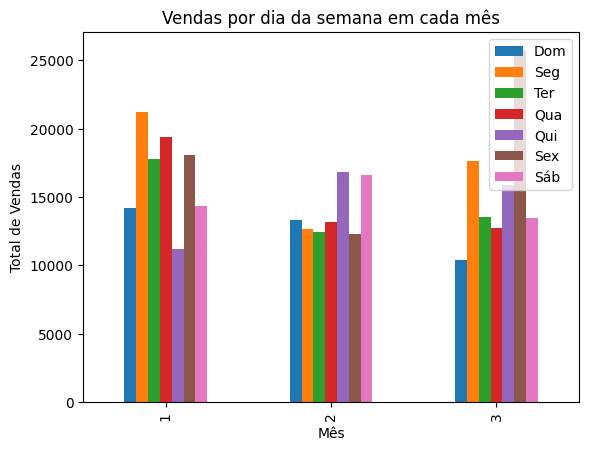

In [685]:
#Comparando as vendas por semana em cada mês

dfDiaSemana.groupby(['Month','Weekday'], observed=True)['Total'].sum().unstack().plot(kind='bar')
plt.title('Vendas por dia da semana em cada mês')
plt.xlabel('Mês')
plt.ylabel('Total de Vendas')
plt.legend(loc='upper right')
plt.show()

# Insights e Análises Importantes

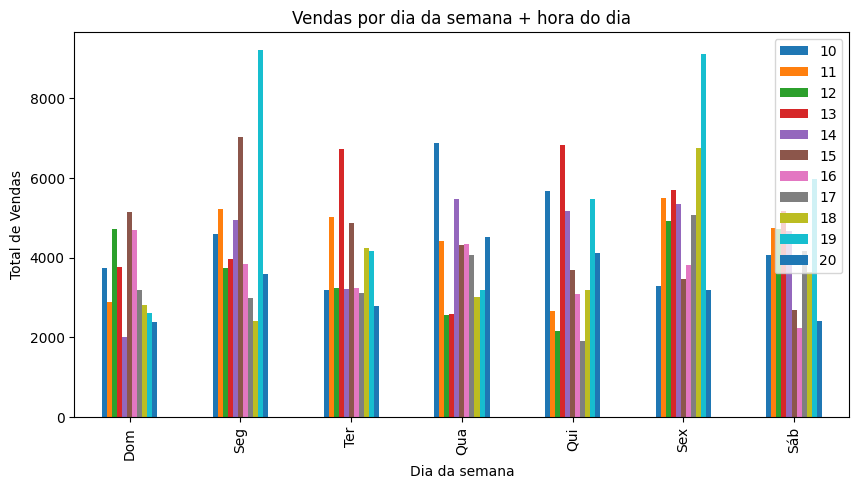

In [686]:
#Verificando sazonalidades por horário e dia da semana

dfDiaSemana.groupby(['Weekday','Hour'], observed=True)['Total'].sum().unstack().plot(kind='bar', figsize=(10,5))
plt.title('Vendas por dia da semana + hora do dia')
plt.xlabel('Dia da semana')
plt.ylabel('Total de Vendas')
plt.legend(loc='upper right')
plt.show()

-> é possível perceber quais os horários de pico de venda por dia

### Séries temporais com base no gráfico acima

In [687]:
pass

# Segmentação de clientes (Clusterização)

In [688]:
#K-Means Clustering: segmentar os clientes em grupos com base em padrões de compra

#selecionando as features para clusterização
features = ['Payment', 'Unit price', 'Quantity']

#one-hot encoding para variáveis categóricas
features_categoricas = ['Payment']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), features_categoricas)],
    remainder='passthrough')

df_encoded = preprocessor.fit_transform(df[features])

#normalização
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

#clusterização
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(df_scaled)

#atribui os clusters ao dataframe
df['Cluster'] = kmeans.labels_

#silhouette score:
silhouette_normal = silhouette_score(df_scaled, kmeans.labels_)
print(f'silhouette score: {silhouette_normal}')

silhouette score: 0.4951420097160493


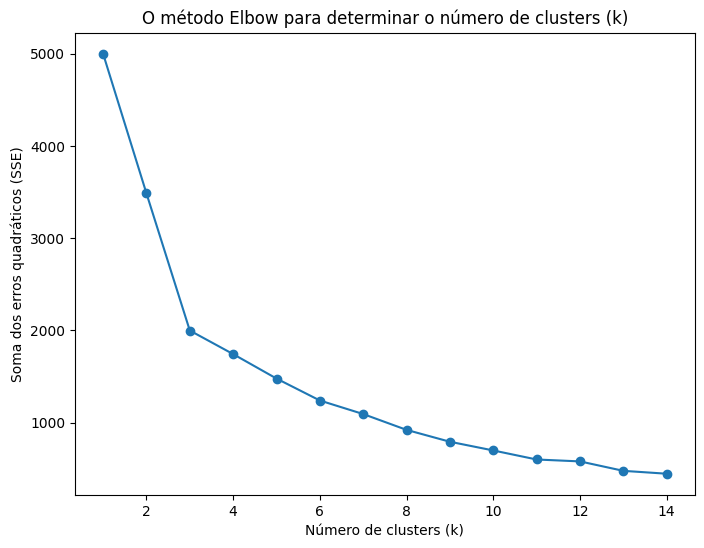

In [689]:
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled)
    sse.append(km.inertia_)

#plot do Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Soma dos erros quadráticos (SSE)')
plt.title('O método Elbow para determinar o número de clusters (k)')
plt.show()

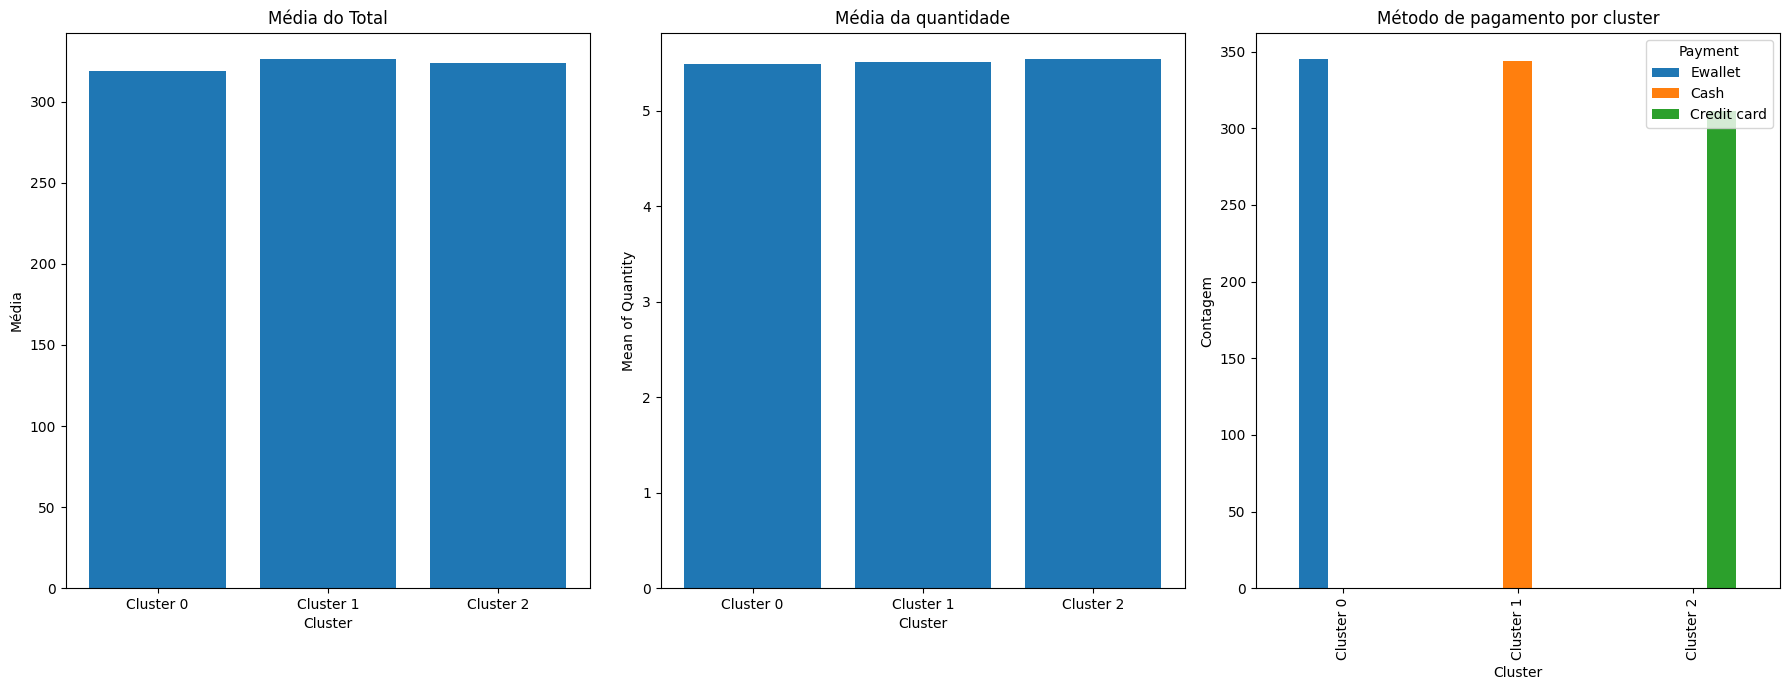

In [690]:
#subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 7))

#média do total
axs[0].bar(range(3), df.groupby('Cluster')['Total'].mean())
axs[0].set_xticks(range(3))
axs[0].set_xticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2'])
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Média')
axs[0].set_title('Média do Total')

#média da quantidade
axs[1].bar(range(3), df.groupby('Cluster')['Quantity'].mean())
axs[1].set_xticks(range(3))
axs[1].set_xticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2'])
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Mean of Quantity')
axs[1].set_title('Média da quantidade')

#método de pagamento utilizado por cluster
df['Payment'] = df['Payment'].astype('category')
df['Payment'] = df['Payment'].cat.reorder_categories(['Ewallet', 'Cash', 'Credit card'], ordered=True)
df.groupby(['Cluster', 'Payment'], observed=True).size().unstack().plot(kind='bar', ax=axs[2])
axs[2].set_title('Método de pagamento por cluster')
axs[2].set_ylabel('Contagem')
axs[2].set_xlabel('Cluster')
axs[2].legend(title='Payment')
axs[2].set_xticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2'])
axs[2].set_xticks(range(3))

plt.tight_layout()

plt.show()

Com o auxílio da clusterização, foi possível identificar com base no método de pagamento padrões para agrupar clientes